In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.model_selection import GridSearchCV

import time

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv('data/bank-full.csv', sep=';')

In [3]:
df.shape

(45211, 17)

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
# df['quality_class'] = 'high'
# df.loc[df['quality']<6, 'quality_class'] = 'low'

# df.drop('quality', axis=1, inplace=True)


In [7]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

df_cat = pd.get_dummies(df[cat_columns])
df = pd.merge(df.drop(cat_columns, axis=1), df_cat, left_index=True, right_index=True)

# label
label = 'y'
df[label] = df[label].map({'yes':1, 'no':0})

In [8]:
df['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

# Data preprocessing

In [9]:
# stratified train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), 
                                                    df.loc[:,label], 
                                                    test_size=0.3, 
                                                    random_state=123,
                                                    stratify=df.loc[:,label])

In [10]:
# normalize data
# X_ = df.drop('y', axis=1)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), 
                 columns=X_train.columns, 
                 index=X_train.index)

X_test = pd.DataFrame(scaler.transform(X_test), 
                 columns=X_test.columns, 
                 index=X_test.index)
# df = X.merge(df.loc[:, 'quality_class'].to_frame(), left_index=True, right_index=True)

In [12]:
# # startified sample for train test split
# sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
# for train_index, test_index in sss.split(X, df[label]):
#     print(train_index)
#     print('----------------------')
#     print(test_index)
# #     X_train, X_test = X[train_index], X[test_index]
# #     y_train, y_test = y[train_index], y[test_index]
#     X[train_index]

In [13]:
# downsample to deal with imbalanced data
X_all = pd.concat([X_train, y_train], axis=1)

X_0, X_1 = X_all[X_all[label]==0], X_all[X_all[label]==1]

# down-sample the majority class
X_downsampled = resample(X_0,
                         replace=False,
                         n_samples=len(X_1),
                         random_state=123)

X_train = pd.concat([X_downsampled, X_1])

y_train = X_train.loc[:, label]
X_train = X_train.drop(label, axis=1)

y_train.value_counts()

1    3702
0    3702
Name: y, dtype: int64

In [11]:
train_time_dict = {}
pred_time_dict = {}
accuracy_dict = {}
f1_dict = {}

# Decision Tree

In [12]:
dt = DecisionTreeClassifier()

t_start = time.time()
dt.fit(X_train, y_train)
t_end = time.time()
train_time_dict['Decision Tree'] = round(t_end - t_start, 4)

In [13]:
dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [14]:
# print(classification_report(y_pred_dt, y_train))

Text(0, 0.5, 'score')

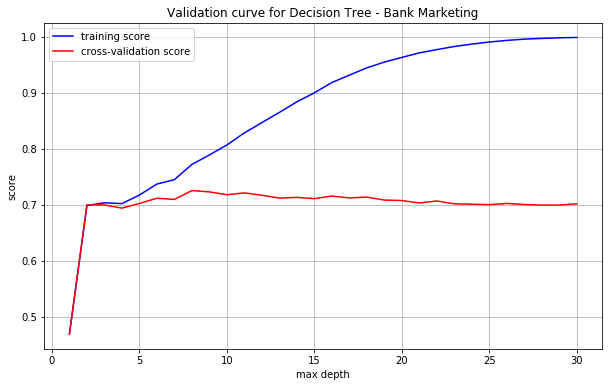

In [15]:
# validation curve
train_scores, validation_scores = validation_curve(dt,
                                                   X_train, 
                                                   y_train, 
                                                   'max_depth',
                                                   range(1, 31),
                                                   scoring='f1_macro',
                                                   cv=5)

# plot
plt.figure(figsize=(10,6))
x_cord = range(1, 31)
y_cord_train = np.mean(train_scores, axis=1)
y_cord_val = np.mean(validation_scores, axis=1)
plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Validation curve for Decision Tree - Bank Marketing')
plt.xlabel('max depth')
plt.ylabel('score')

In [16]:
# Hyperparameter tuning. 
param_dict = {
    "max_depth": range(5, 10),
    "min_samples_split":range(1, 20),
}

grid = GridSearchCV(dt, 
                    param_grid=param_dict, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring='f1_macro')
grid.fit(X_train, y_train)


Fitting 5 folds for each of 95 candidates, totalling 475 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 475 out of 475 | elapsed:   17.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(5, 10),
                         'mi

In [17]:
print(grid.best_params_)
print(grid.best_score_)
dt = grid.best_estimator_

{'max_depth': 8, 'min_samples_split': 14}
0.7272130183571079


In [18]:
dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [19]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(dt,
                                                        X_train, 
                                                        y_train, 
                                                        train_sizes=train_sizes, 
                                                        scoring='f1_macro',
                                                        cv=5)

Text(0, 0.5, 'score')

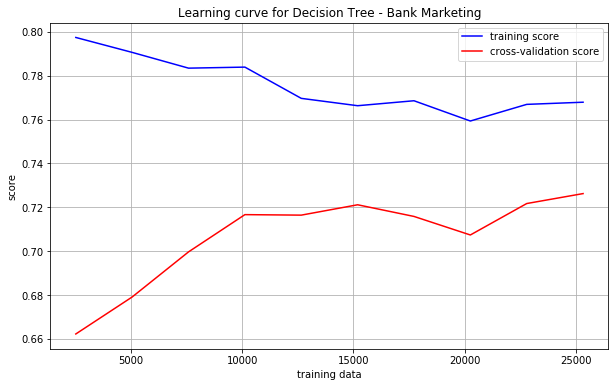

In [20]:
plt.figure(figsize=(10,6))
x_cord = train_sizes
y_cord_train = np.mean(train_scores, axis=1)
y_cord_val = np.mean(test_scores, axis=1)
plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Learning curve for Decision Tree - Bank Marketing')
plt.xlabel('training data')
plt.ylabel('score')

In [21]:
model_name = 'Decision Tree'
t_start = time.time()
y_pred_dt = dt.predict(X_test)
t_end = time.time()
pred_time = t_end - t_start

pred_time_dict[model_name] = round(pred_time, 4)
accuracy_dict[model_name] = round(accuracy_score(y_test, y_pred_dt), 4)
f1_dict[model_name] = round(f1_score(y_test, y_pred_dt, average='macro'), 4)

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11977
           1       0.62      0.37      0.46      1587

    accuracy                           0.90     13564
   macro avg       0.77      0.67      0.70     13564
weighted avg       0.89      0.90      0.89     13564



# Neural Networks

In [22]:
nn = MLPClassifier()

t_start = time.time()
nn.fit(X_train, y_train)
t_end = time.time()
train_time_dict['Neural Network'] = round(t_end - t_start, 4)


In [23]:
nn

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Text(0, 0.5, 'score')

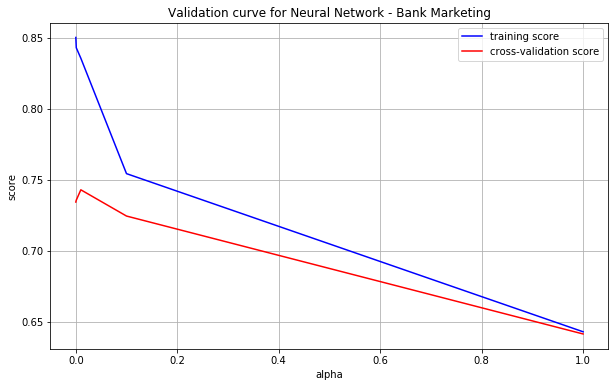

In [24]:
# validation curve
alpha = np.logspace(-4, 0, 5)
train_scores, validation_scores = validation_curve(nn,
                                                   X_train, 
                                                   y_train, 
                                                   'alpha',
                                                   alpha,
                                                   scoring='f1_macro',
                                                   cv=5)

# plot
plt.figure(figsize=(10,6))
x_cord = alpha
y_cord_train = np.mean(train_scores, axis=1)
y_cord_val = np.mean(validation_scores, axis=1)
plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Validation curve for Neural Network - Bank Marketing')
plt.xlabel('alpha')
plt.ylabel('score')

In [25]:
# Hyperparameter tuning. 
param_dict = {
    'alpha': np.logspace(-3, 1, 5),
    'hidden_layer_sizes': [(20, 10), (10, 5), (5, 2), (3, 1)],
}

grid = GridSearchCV(nn, 
                    param_grid = param_dict, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring='f1_macro'
                   )
grid.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'

In [26]:
print(grid.best_params_)
print(grid.best_score_)
nn = grid.best_estimator_
alpha = grid.best_params_['alpha']
hidden_layer_sizes = grid.best_params_['hidden_layer_sizes']

{'alpha': 0.1, 'hidden_layer_sizes': (20, 10)}
0.753818690589139


In [27]:
nn

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [28]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(nn,
                                                        X_train, 
                                                        y_train, 
                                                        train_sizes=train_sizes,
                                                        scoring='f1_macro',
                                                        cv=5)

Text(0, 0.5, 'score')

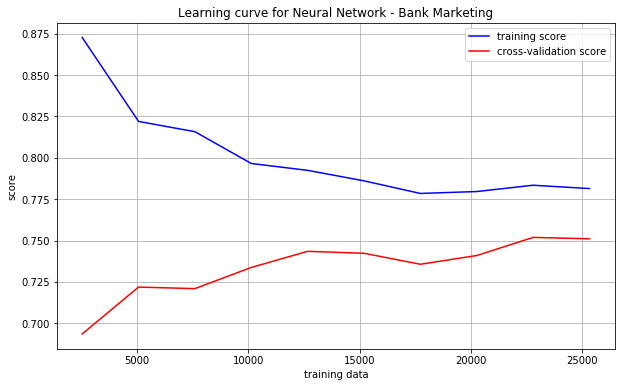

In [29]:
plt.figure(figsize=(10,6))
x_cord = train_sizes
y_cord_train = np.mean(train_scores, axis=1)
y_cord_val = np.mean(test_scores, axis=1)
plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Learning curve for Neural Network - Bank Marketing')
plt.xlabel('training data')
plt.ylabel('score')

In [30]:
X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train,
                                                                 y_train, 
                                                                 test_size=0.2,
                                                                 random_state=123
                                                                 )

epochs = 200
train_score, val_score = {}, {}

nn_tmp = MLPClassifier(alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, max_iter=1, warm_start=True)

for i in range(epochs):
    nn_tmp.fit(X_train_tmp, y_train_tmp)
    train_score[i] = f1_score(y_train_tmp, nn_tmp.predict(X_train_tmp), average='macro')
    val_score[i] = f1_score(y_val_tmp, nn_tmp.predict(X_val_tmp), average='macro')

    

Text(0, 0.5, 'score')

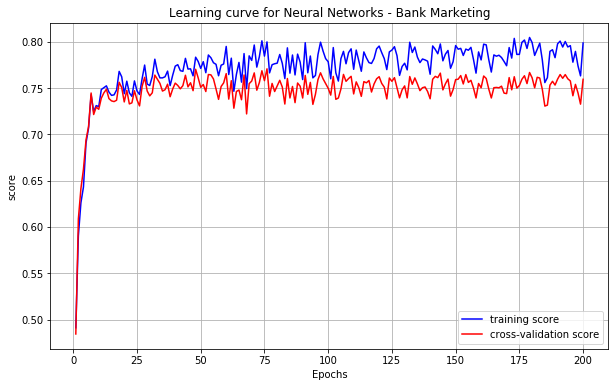

In [31]:
plt.figure(figsize=(10,6))
x_cord = list(range(1, epochs+1))
# y_cord_train = np.mean(train_scores, axis=1)
y_cord_train = pd.DataFrame.from_dict(train_score, orient='index')
# y_cord_val = np.mean(validation_scores, axis=1)
y_cord_val = pd.DataFrame.from_dict(val_score, orient='index')

plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Learning curve for Neural Networks - Bank Marketing')
plt.xlabel('Epochs')
plt.ylabel('score')

In [32]:
model_name = 'Neural Network'
t_start = time.time()
y_pred_nn = nn_tmp.predict(X_test)
t_end = time.time()
pred_time = t_end - t_start

pred_time_dict[model_name] = round(pred_time, 4)
accuracy_dict[model_name] = round(accuracy_score(y_test, y_pred_nn), 4)
f1_dict[model_name] = round(f1_score(y_test, y_pred_nn, average='macro'), 4)
print(classification_report(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     11977
           1       0.60      0.54      0.57      1587

    accuracy                           0.90     13564
   macro avg       0.77      0.74      0.76     13564
weighted avg       0.90      0.90      0.90     13564



# Boosting

In [33]:
adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

t_start = time.time()
adb.fit(X_train, y_train)
t_end = time.time()
train_time_dict['AdaBoost'] = round(t_end - t_start, 4)


In [34]:
adb

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [35]:
# validation curve
n_estimators = list(range(1, 500, 5))
train_scores, validation_scores = validation_curve(adb,
                                                   X_train, 
                                                   y_train, 
                                                   'n_estimators',
                                                   n_estimators,
                                                   scoring='f1_macro',
                                                   cv=5)

# plot
plt.figure(figsize=(10,6))
x_cord = n_estimators
y_cord_train = np.mean(train_scores, axis=1)
y_cord_val = np.mean(validation_scores, axis=1)
plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Validation curve for AdaBoost - Bank Marketing')
plt.xlabel('# of weak learners')
plt.ylabel('score')

KeyboardInterrupt: 

In [36]:
# Hyperparameter tuning. 
param_dict = {
    'n_estimators': range(20, 100),
    'learning_rate': np.logspace(-5,1,7)
}

grid = GridSearchCV(adb, 
                  param_grid = param_dict, 
                  cv=5, 
                  verbose=1, 
                  n_jobs=-1,
                  scoring='f1_macro')
grid.fit(X_train, y_train)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 15.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
    

In [37]:
print(grid.best_params_)
print(grid.best_score_)
adb = grid.best_estimator_

{'learning_rate': 1.0, 'n_estimators': 53}
0.7111191279309322


In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(adb,
                                                       X_train, 
                                                       y_train, 
                                                       train_sizes=train_sizes, 
                                                       scoring='f1_macro',
                                                       cv=5)

In [ ]:
plt.figure(figsize=(10,6))
x_cord = train_sizes
y_cord_train = np.mean(train_scores, axis=1)
y_cord_val = np.mean(test_scores, axis=1)
plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Learning curve for AdaBoost - Bank Marketing')
plt.xlabel('training data')
plt.ylabel('score')

In [38]:
model_name = 'AdaBoost'
t_start = time.time()
y_pred_adb = adb.predict(X_test)
t_end = time.time()
pred_time = t_end - t_start

pred_time_dict[model_name] = round(pred_time, 4)
accuracy_dict[model_name] = round(accuracy_score(y_test, y_pred_adb), 4)
f1_dict[model_name] = round(f1_score(y_test, y_pred_adb, average='macro'), 4)
print(classification_report(y_test, y_pred_adb))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11977
           1       0.63      0.36      0.46      1587

    accuracy                           0.90     13564
   macro avg       0.77      0.67      0.70     13564
weighted avg       0.89      0.90      0.89     13564



# Support Vector Machines

In [39]:
svm = SVC(kernel='linear')
t_start = time.time()
svm.fit(X_train, y_train)
t_end = time.time()

train_time_dict['SVM'] = round(t_end - t_start, 4)

In [ ]:
svm

In [ ]:
# validation curve
c = np.logspace(-5,1,7)
train_scores, validation_scores = validation_curve(svm,
                                                   X_train, 
                                                   y_train, 
                                                   'C',
                                                   c,
                                                   scoring='f1_macro',
                                                   cv=5)

# plot
plt.figure(figsize=(10,6))
x_cord = c
y_cord_train = np.mean(train_scores, axis=1)
y_cord_val = np.mean(validation_scores, axis=1)
plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Validation curve for SVM - Bank Marketing')
plt.xlabel('alpha')
plt.ylabel('score')

In [40]:
# Hyperparameter tuning. 
param_dict = {
    'C': np.logspace(-4,0,5),
    'kernel': ['linear', 'rbf']
}

grid = GridSearchCV(svm, 
                    param_grid = param_dict, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring='f1_macro')
grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=1)

In [41]:
print(grid.best_params_)
print(grid.best_score_)
svm = grid.best_estimator_

{'C': 1.0, 'kernel': 'rbf'}
0.6243077162874593


In [ ]:
svm

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm,
                                                        X_train, 
                                                        y_train, 
                                                        train_sizes=train_sizes, 
                                                        scoring='f1_macro',
                                                        cv=5)

In [ ]:
plt.figure(figsize=(10,6))
x_cord = train_sizes
y_cord_train = np.mean(train_scores, axis=1)
y_cord_val = np.mean(test_scores, axis=1)
plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Learning curve for SVM - Bank Marketing')
plt.xlabel('training data')
plt.ylabel('score')

In [42]:
model_name = 'SVM'
t_start = time.time()
y_pred_svm = svm.predict(X_test)
t_end = time.time()
pred_time = t_end - t_start

pred_time_dict[model_name] = round(pred_time, 4)
accuracy_dict[model_name] = round(accuracy_score(y_test, y_pred_svm), 4)
f1_dict[model_name] = round(f1_score(y_test, y_pred_svm, average='macro'), 4)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11977
           1       0.67      0.21      0.32      1587

    accuracy                           0.90     13564
   macro avg       0.79      0.60      0.63     13564
weighted avg       0.88      0.90      0.87     13564



# K-Nearest Neighbors

In [43]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)




KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn

In [ ]:
# validation curve
k = list(range(1, 101, 2))
train_scores, validation_scores = validation_curve(knn,
                                                   X_train, 
                                                   y_train, 
                                                   'n_neighbors',
                                                   k,
                                                   scoring='f1_macro',
                                                   cv=5)

# plot
plt.figure(figsize=(10,6))
x_cord = k
y_cord_train = np.mean(train_scores, axis=1)
y_cord_val = np.mean(validation_scores, axis=1)
plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Validation curve for KNN - Bank Marketing')
plt.xlabel('# neighbors')
plt.ylabel('score')

In [44]:
# Hyperparameter tuning. 
param_dict = {
    'n_neighbors': range(10, 18),
}

grid = GridSearchCV(knn, 
                    param_grid = param_dict, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring='f1_macro')
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': range(10, 18)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='f1_macro',
             verbose=1)

In [45]:
print(grid.best_params_)
print(grid.best_score_)
knn = grid.best_estimator_

{'n_neighbors': 11}
0.6112061281798625


In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(knn,
                                                        X_train, 
                                                        y_train, 
                                                        train_sizes=train_sizes, 
                                                        scoring='f1_macro',
                                                        cv=5)

In [ ]:
plt.figure(figsize=(10,6))
x_cord = train_sizes
y_cord_train = np.mean(train_scores, axis=1)
y_cord_val = np.mean(test_scores, axis=1)
plt.plot(x_cord, y_cord_train, color='b', label='training score')
plt.plot(x_cord, y_cord_val, color='r', label='cross-validation score')
plt.grid()
plt.legend()
plt.title('Learning curve for KNN - Bank Marketing')
plt.xlabel('training data')
plt.ylabel('score')

In [ ]:
model_name = 'KNN'
t_start = time.time()
y_pred_knn = knn.predict(X_test)
t_end = time.time()
pred_time = t_end - t_start

pred_time_dict[model_name] = round(pred_time, 4)
accuracy_dict[model_name] = round(accuracy_score(y_test, y_pred_knn), 4)
f1_dict[model_name] = round(f1_score(y_test, y_pred_knn, average='macro'), 4)
print(classification_report(y_test, y_pred_knn))

In [ ]:
plt.figure(figsize=(10,6))
df_train_time = pd.DataFrame.from_dict(train_time_dict, orient='index').reset_index()
df_train_time.columns = ['algorithms', 'time']
ax = sns.barplot(x='algorithms', y='time', data=df_train_time)
plt.title('Training time comparison - Bank Marketing')

In [ ]:

plt.figure(figsize=(10,6))
df_pred_time = pd.DataFrame.from_dict(pred_time_dict, orient='index').reset_index()
df_pred_time.columns = ['algorithms', 'time']
ax = sns.barplot(x='algorithms', y='time', data=df_pred_time)
plt.title('Prediction time comparison - Bank Marketing')

In [ ]:

plt.figure(figsize=(10,6))
df_accuracy = pd.DataFrame.from_dict(accuracy_dict, orient='index').reset_index()
df_accuracy.columns = ['algorithms', 'accuracy']
ax = sns.barplot(x='algorithms', y='accuracy', data=df_accuracy)
plt.title('Accuracy comparison - Bank Marketing')
ax.set_ylim(0.5,1)

In [ ]:

plt.figure(figsize=(10,6))
df_f1 = pd.DataFrame.from_dict(f1_dict, orient='index').reset_index()
df_f1.columns = ['algorithms', 'f1']
ax = sns.barplot(x='algorithms', y='f1', data=df_f1)
plt.title('F1 comparison - Bank Marketing')
ax.set_ylim(0.5,1)
